In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from google.colab import files
import io

# Upload the dataset using file browsing
uploaded = files.upload()

# Read the uploaded CSV file into a pandas DataFrame
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    df = pd.read_csv(io.StringIO(uploaded[fn].decode('utf-8')))

# Display the first few rows
print(df.head())
print(df.describe())

Saving StressLevelDataset.csv to StressLevelDataset (1).csv
User uploaded file "StressLevelDataset (1).csv" with length 48717 bytes
   anxiety_level  self_esteem  mental_health_history  depression  headache  \
0             14           20                      0          11         2   
1             15            8                      1          15         5   
2             12           18                      1          14         2   
3             16           12                      1          15         4   
4             16           28                      0           7         2   

   blood_pressure  sleep_quality  breathing_problem  noise_level  \
0               1              2                  4            2   
1               3              1                  4            3   
2               1              2                  2            2   
3               3              1                  3            4   
4               3              5                  1        

# Handling missing data (IT24100967)

Checking for missing values in each column:
There are no missing values in the dataset.


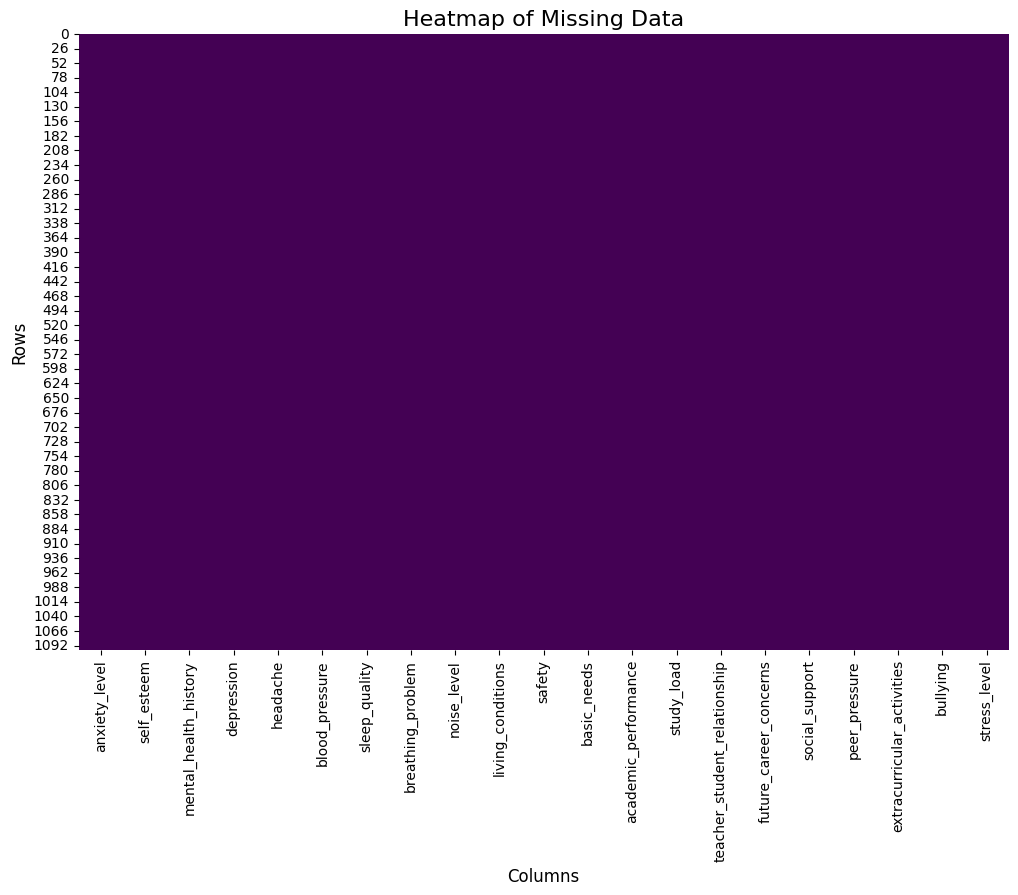

In [5]:
#Check for missing data programmatically
print("Checking for missing values in each column:")
missing_values = df.isnull().sum()

if missing_values.sum() == 0:
    print("There are no missing values in the dataset.")
else:
        print("Missing values found in the following columns:")
        print(missing_values[missing_values > 0])


#Visualize the missing data
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Data', fontsize=16)
plt.xlabel('Columns', fontsize=12)
plt.ylabel('Rows', fontsize=12)
plt.savefig('missing_data_heatmap.jpg') # Save the figure
plt.show()

# Encoding categorical variables (IT24100890)


--- Apply Encoding ---
Encoded DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   anxiety_level                 1100 non-null   int64
 1   self_esteem                   1100 non-null   int64
 2   mental_health_history         1100 non-null   int64
 3   depression                    1100 non-null   int64
 4   headache                      1100 non-null   int64
 5   blood_pressure                1100 non-null   int64
 6   sleep_quality                 1100 non-null   int64
 7   breathing_problem             1100 non-null   int64
 8   noise_level                   1100 non-null   int64
 9   living_conditions             1100 non-null   int64
 10  safety                        1100 non-null   int64
 11  basic_needs                   1100 non-null   int64
 12  academic_performance          1100 non-nul

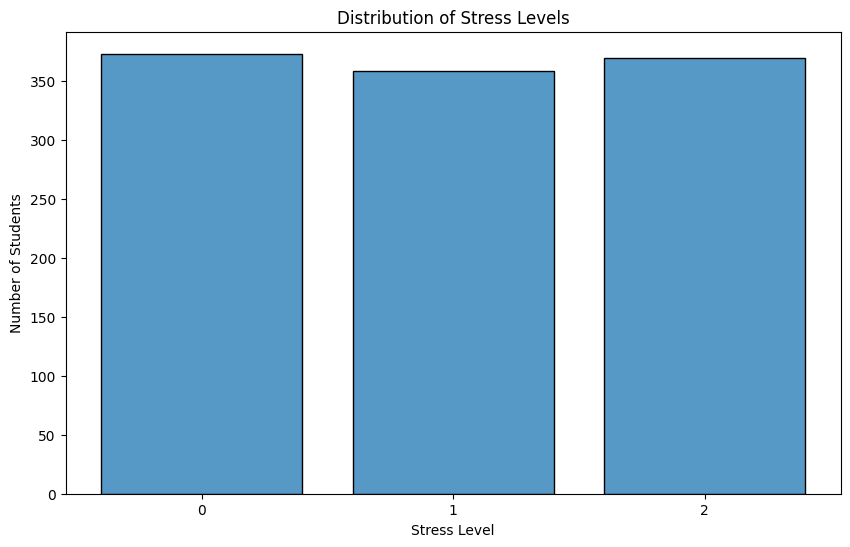

In [6]:
# Apply one-hot encoding
df_encoded = pd.get_dummies(df)

# Show the properties of the encoded DataFrame
print("\n--- Apply Encoding ---")
print("Encoded DataFrame Info:")
df_encoded.info()
print("\nEncoded DataFrame Shape:", df_encoded.shape)

print("\n--- Step 3: Generating and Interpreting a Histogram ---")
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='stress_level', discrete=True, shrink=0.8)
plt.title('Distribution of Stress Levels')
plt.xlabel('Stress Level')
plt.ylabel('Number of Students')
plt.xticks([0, 1, 2])
plt.savefig('stress_level_histogram.jpg') # Save the figure as a JPG file
plt.show()

# Outlier removal (IT24100307)

In [7]:
# Identify scale-like vs continuous columns in your dataset
scale_like_cols = []
continuous_cols = []

for col in df.select_dtypes(include=['number']).columns:
    unique_vals = df[col].nunique()
    col_range = df[col].max() - df[col].min()

    # Heuristic rule:
    # If the column has few unique values (<=15) AND the range is small (<=15),
    # then it's likely a scale/ordinal variable → skip outlier detection
    if unique_vals <= 15 and col_range <= 15:
        scale_like_cols.append(col)
    else:
        continuous_cols.append(col)

print("Columns likely SCALE (no outlier detection):", scale_like_cols)
print("Columns likely CONTINUOUS (apply outlier detection):", continuous_cols)

# Calculate and print the mean of continuous columns
print("\nMean of continuous columns:")
print(df[continuous_cols].mean())

Columns likely SCALE (no outlier detection): ['mental_health_history', 'headache', 'blood_pressure', 'sleep_quality', 'breathing_problem', 'noise_level', 'living_conditions', 'safety', 'basic_needs', 'academic_performance', 'study_load', 'teacher_student_relationship', 'future_career_concerns', 'social_support', 'peer_pressure', 'extracurricular_activities', 'bullying', 'stress_level']
Columns likely CONTINUOUS (apply outlier detection): ['anxiety_level', 'self_esteem', 'depression']

Mean of continuous columns:
anxiety_level    11.063636
self_esteem      17.777273
depression       12.555455
dtype: float64


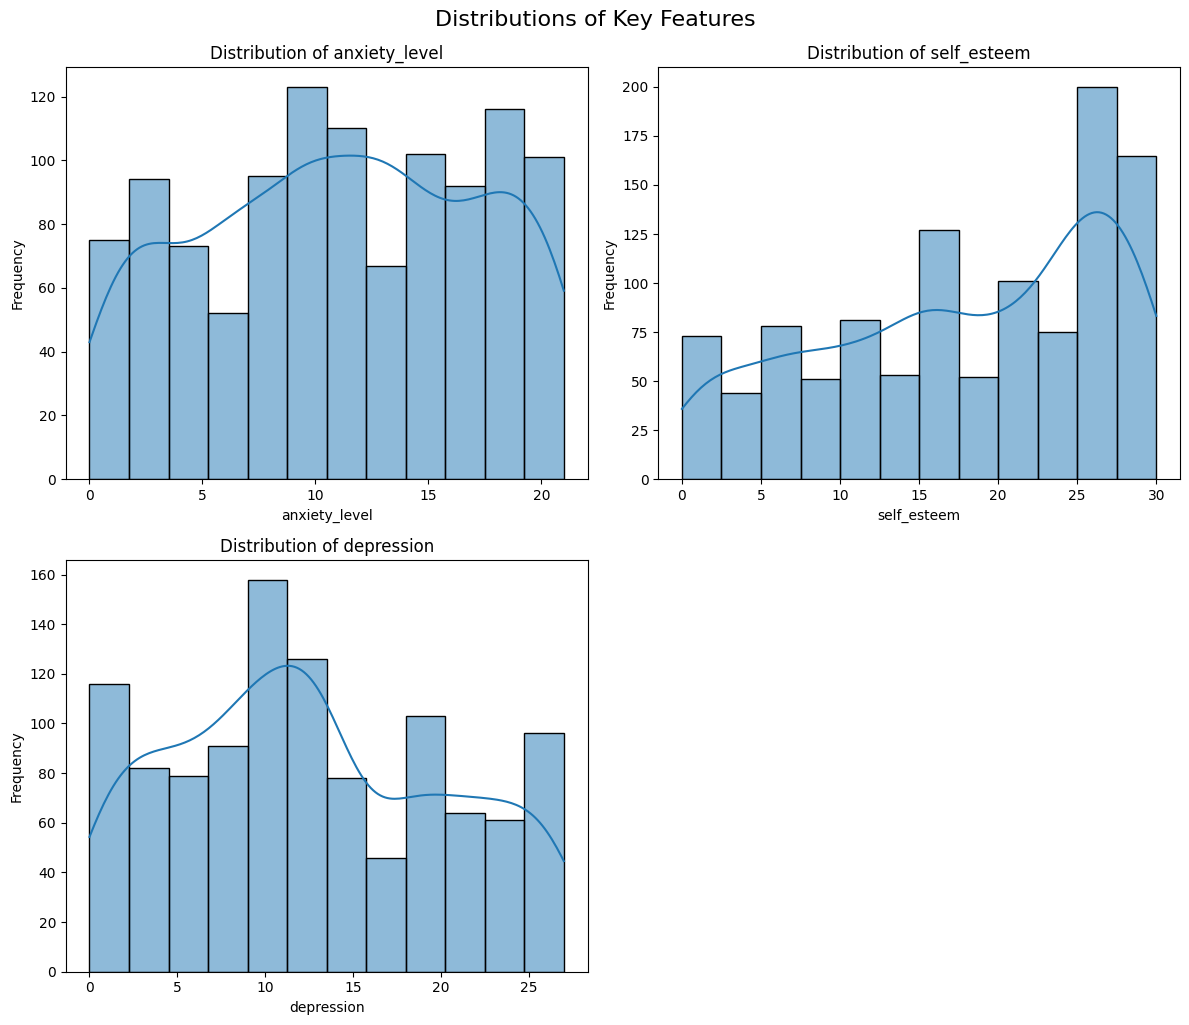

In [8]:
# Select a few key numerical columns for visualization
key_numerical_cols = ['anxiety_level', 'self_esteem', 'depression']

# Create subplots for a selection of histograms
num_cols = len(key_numerical_cols)
num_rows = (num_cols + 1) // 2 # Arrange in 2 columns

fig, axes = plt.subplots(num_rows, 2, figsize=(12, num_rows * 5))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i, col in enumerate(key_numerical_cols):
    sns.histplot(data=df, x=col, kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.suptitle('Distributions of Key Features', y=1.02, fontsize=16) # Add a main title
plt.savefig('distributions_histogram.png') # Save the figure
plt.show()

In [9]:
columns_to_check = ['anxiety_level', 'self_esteem', 'depression']
print("\n--- Outlier Detection Report ---")

for col in columns_to_check:
    print(f"\nChecking column: '{col}'")

    # Calculate Q1, Q3, and IQR
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

    # --- Step 3: Report the Findings ---
    if not outliers.empty:
        print(f"Found {len(outliers)} outliers.")
        # Display the first 5 outlier rows for inspection
        print("Here are some of the outlier rows:")
        print(outliers.head())
    else:
        print("No outliers detected.")


--- Outlier Detection Report ---

Checking column: 'anxiety_level'
No outliers detected.

Checking column: 'self_esteem'
No outliers detected.

Checking column: 'depression'
No outliers detected.


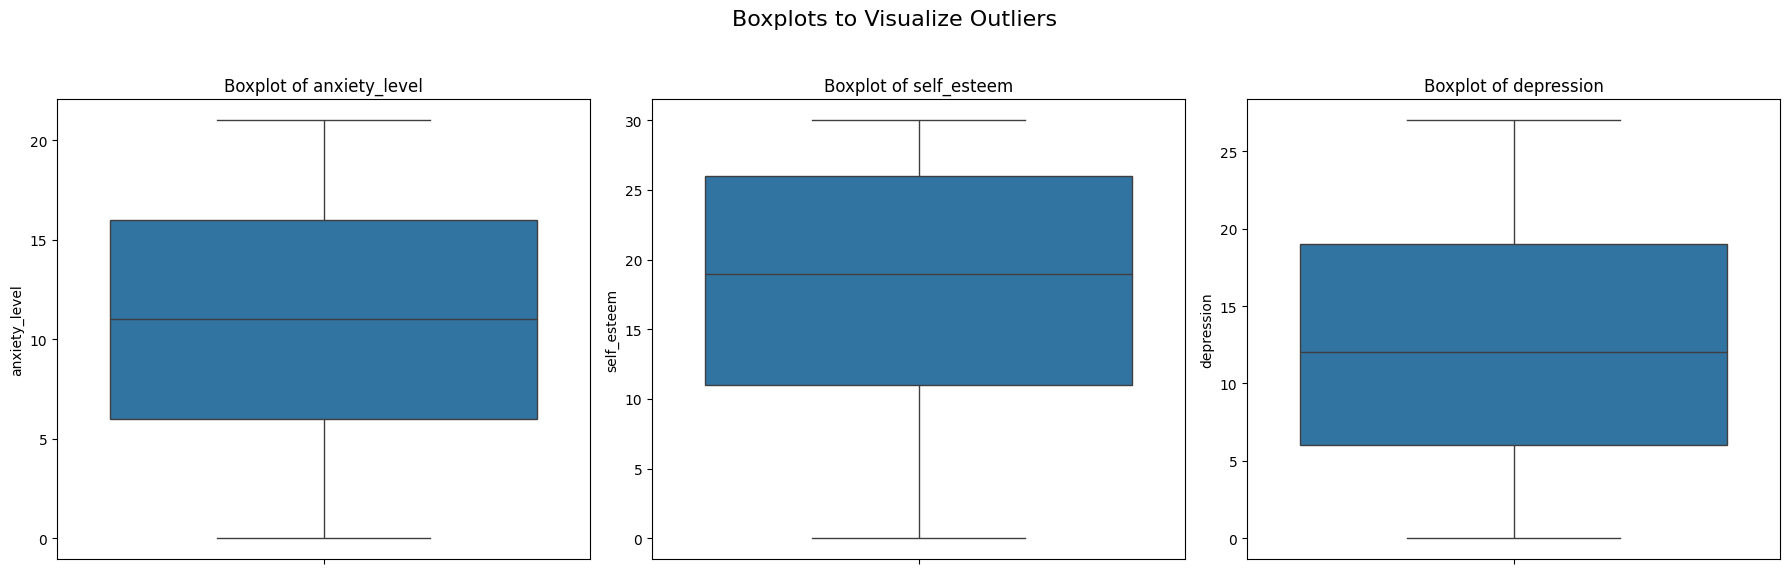

In [10]:
columns_to_plot = ['anxiety_level', 'self_esteem', 'depression']

# This sets up a figure that will hold our three plots side-by-side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Add a main title to the entire figure
fig.suptitle('Boxplots to Visualize Outliers', fontsize=16)

# Loop through each column and create a boxplot for it
for i, col in enumerate(columns_to_plot):
    sns.boxplot(y=df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
    axes[i].set_ylabel(col)

# Adjust the layout to prevent titles from overlapping
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# This will save the generated image as a PNG file.
plt.savefig('outlier_boxplots.png')


# Normalization / scaling (IT24104387)

In [11]:
# Technique: Min-Max Scaling on all numerical features
features = df.drop('stress_level', axis=1)  # Exclude target
scaler = MinMaxScaler()  # Initialize scaler (default range [0,1])
df_scaled = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)  # Scale and create new DF
df_scaled['stress_level'] = df['stress_level']  # Add back the target column (unchanged)

# Output: Summary statistics after scaling
print(df_scaled.describe())

       anxiety_level  self_esteem  mental_health_history   depression  \
count    1100.000000  1100.000000            1100.000000  1100.000000   
mean        0.526840     0.592576               0.492727     0.465017   
std         0.291312     0.298153               0.500175     0.286185   
min         0.000000     0.000000               0.000000     0.000000   
25%         0.285714     0.366667               0.000000     0.222222   
50%         0.523810     0.633333               0.000000     0.444444   
75%         0.761905     0.866667               1.000000     0.703704   
max         1.000000     1.000000               1.000000     1.000000   

          headache  blood_pressure  sleep_quality  breathing_problem  \
count  1100.000000     1100.000000    1100.000000        1100.000000   
mean      0.501636        0.590909       0.532000           0.550727   
std       0.281871        0.416787       0.309677           0.280143   
min       0.000000        0.000000       0.000000     

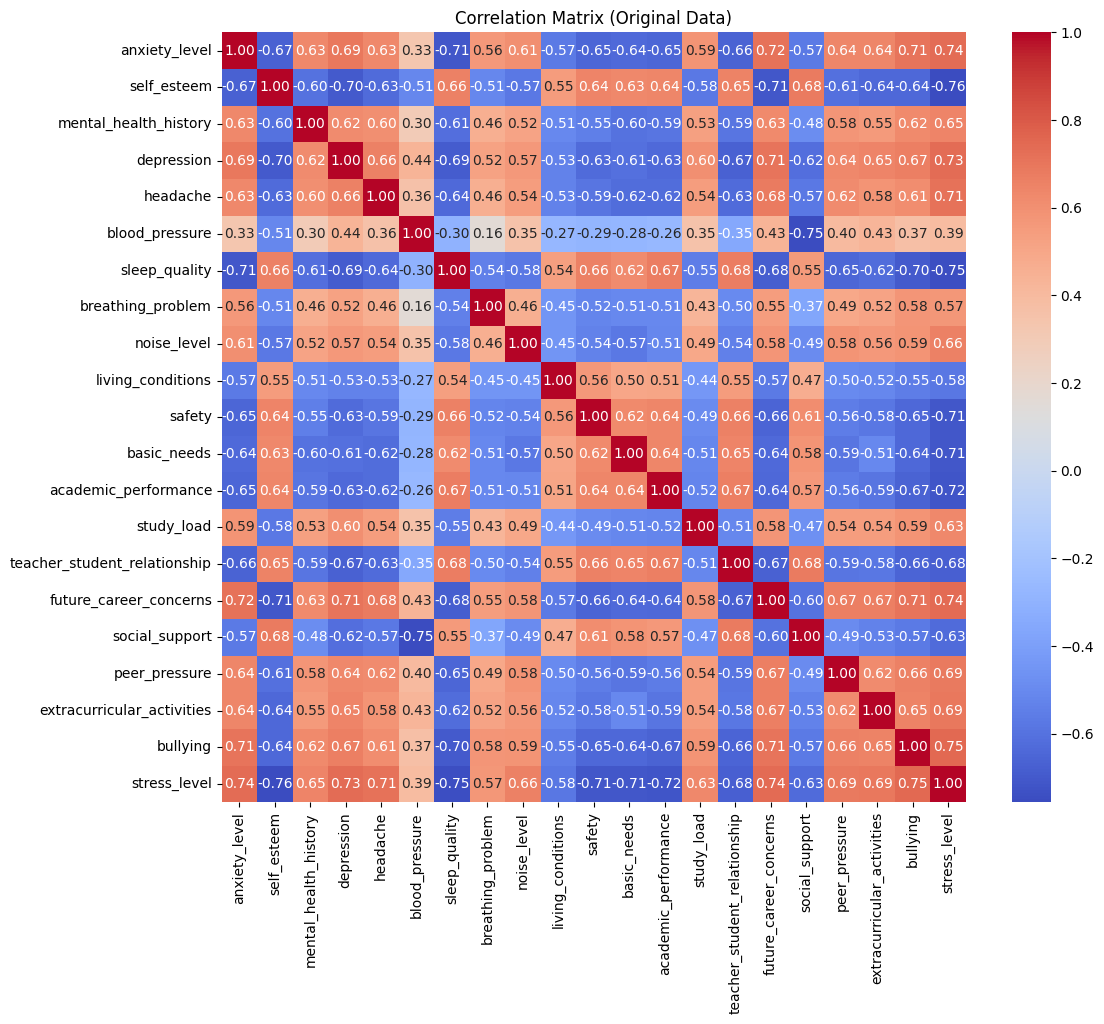

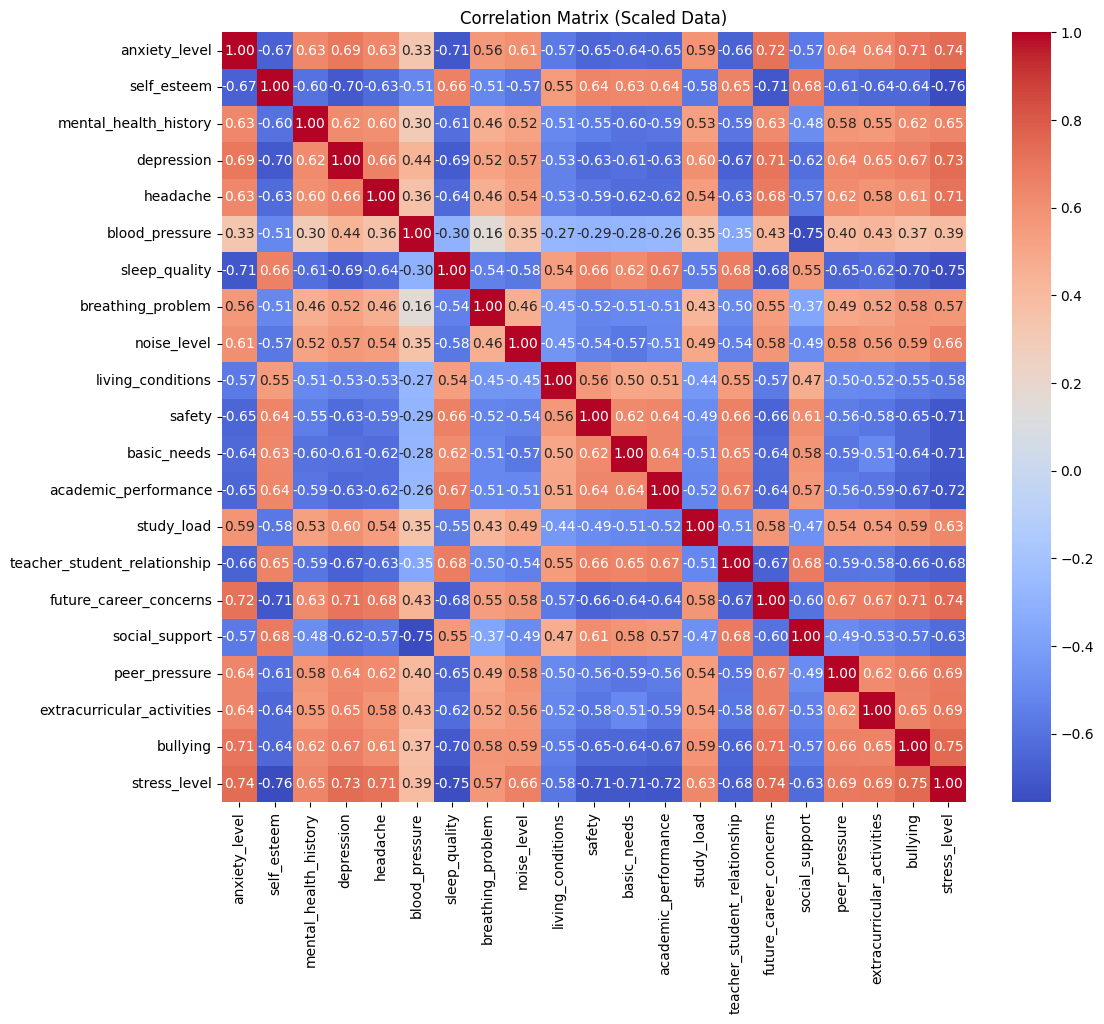

In [12]:
# EDA: Correlation heatmap (before scaling)
plt.figure(figsize=(12,10))  # Set figure size for readability
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')  # Heatmap with annotations (2 decimal places)
plt.title('Correlation Matrix (Original Data)')  # Title
plt.savefig('Original_corr_heatmap.jpg')  # Save to the current directory
plt.show()  # Display in notebook

# EDA: Correlation heatmap (after scaling)
plt.figure(figsize=(12,10))  # Set figure size for readability
sns.heatmap(df_scaled.corr(), annot=True, cmap='coolwarm', fmt='.2f')  # Heatmap with annotations (2 decimal places)
plt.title('Correlation Matrix (Scaled Data)')  # Title
plt.savefig('Scaled_corr_heatmap.jpg')  # Save to the current directory
plt.show()  # Display in notebook

In [13]:
display(df_scaled.head())

,anxiety_level,self_esteem,mental_health_history,depression,headache,blood_pressure,sleep_quality,breathing_problem,noise_level,living_conditions,...,basic_needs,academic_performance,study_load,teacher_student_relationship,future_career_concerns,social_support,peer_pressure,extracurricular_activities,bullying,stress_level
0,0.666667,0.666667,0.0,0.407407,0.4,0.0,0.4,0.8,0.4,0.6,...,0.4,0.6,0.4,0.6,0.6,0.666667,0.6,0.6,0.4,1
1,0.714286,0.266667,1.0,0.555556,1.0,1.0,0.2,0.8,0.6,0.2,...,0.4,0.2,0.8,0.2,1.0,0.333333,0.8,1.0,1.0,2
2,0.571429,0.600000,1.0,0.518519,0.4,0.0,0.4,0.4,0.4,0.4,...,0.4,0.4,0.6,0.6,0.4,0.666667,0.6,0.4,0.4,1
3,0.761905,0.400000,1.0,0.555556,0.8,1.0,0.2,0.6,0.8,0.4,...,0.4,0.4,0.8,0.2,0.8,0.333333,0.8,0.8,1.0,2
4,0.761905,0.933333,0.0,0.259259,0.4,1.0,1.0,0.2,0.6,0.4,...,0.6,0.8,0.6,0.2,0.4,0.333333,1.0,0.0,1.0,1


#Feature selection (IT24100821)

In [14]:
# Prepare features and target
# Use the scaled dataframe for feature selection
X = df_scaled.drop('stress_level', axis=1)
y = df_scaled['stress_level']

# Initialize and fit Random Forest Classifier
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X, y)

RandomForestClassifier(random_state=42)

In [15]:
# Extract feature importances
importances = rfc.feature_importances_

In [16]:
# Print the sorted feature importances with feature names
print("Sorted Feature Importances:")
# Create a list of tuples with (importance, feature_name)
sorted_importances = sorted(zip(rfc.feature_importances_, X.columns), reverse=True)
for importance, feature in sorted_importances:
    print(f"{feature}: {importance:.4f}")

Sorted Feature Importances:
blood_pressure: 0.1782
sleep_quality: 0.0791
basic_needs: 0.0640
safety: 0.0638
depression: 0.0632
self_esteem: 0.0616
academic_performance: 0.0614
future_career_concerns: 0.0571
social_support: 0.0532
anxiety_level: 0.0507
extracurricular_activities: 0.0447
teacher_student_relationship: 0.0434
headache: 0.0398
bullying: 0.0383
peer_pressure: 0.0381
noise_level: 0.0199
study_load: 0.0155
breathing_problem: 0.0120
living_conditions: 0.0112
mental_health_history: 0.0051


In [17]:
# Get feature importances and select top 15
importances = rfc.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
})
feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
top_15_features = feature_importance_df['feature'].head(15).tolist()

In [18]:
print("Top 15 features selected by Random Forest importance:")
print(top_15_features)

Top 15 features selected by Random Forest importance:
['blood_pressure', 'sleep_quality', 'basic_needs', 'safety', 'depression', 'self_esteem', 'academic_performance', 'future_career_concerns', 'social_support', 'anxiety_level', 'extracurricular_activities', 'teacher_student_relationship', 'headache', 'bullying', 'peer_pressure']


In [19]:
# Create a new dataframe with only top 15 features + target
df_selected = df[top_15_features + ['stress_level']]
print("Selected dataset after removing unnecessary features:")
print(df_selected.head())

Selected dataset after removing unnecessary features:
   blood_pressure  sleep_quality  basic_needs  safety  depression  \
0               1              2            2       3          11   
1               3              1            2       2          15   
2               1              2            2       3          14   
3               3              1            2       2          15   
4               3              5            3       4           7   

   self_esteem  academic_performance  future_career_concerns  social_support  \
0           20                     3                       3               2   
1            8                     1                       5               1   
2           18                     2                       2               2   
3           12                     2                       4               1   
4           28                     4                       2               1   

   anxiety_level  extracurricular_activities  teac

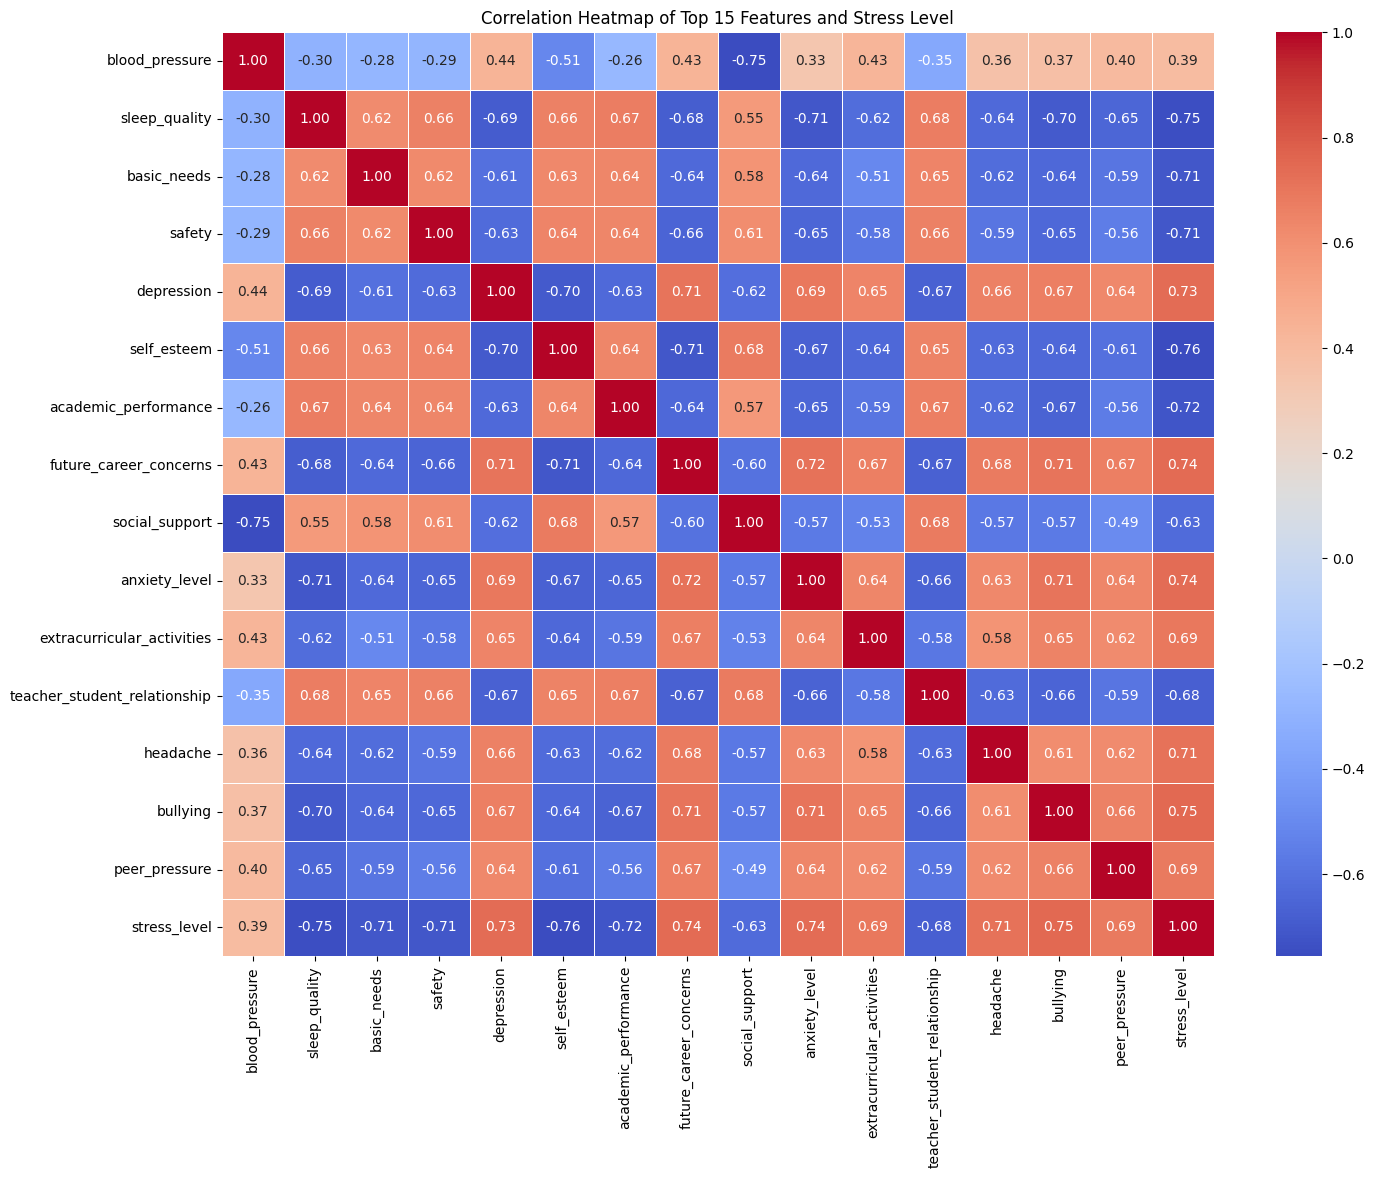

In [20]:
#Compute correlation matrix for selected features (including target)
corr_matrix = df_selected.corr()

# Visualize correlation heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Heatmap of Top 15 Features and Stress Level')
plt.show()

#Dimension reduction (IT24100479)

Explained variance ratio by each component:
[0.61617572 0.11464308 0.03955879 0.02706913 0.02450791 0.02246615
 0.02161363 0.02052722 0.01971312 0.01858159 0.01756368 0.01698229]


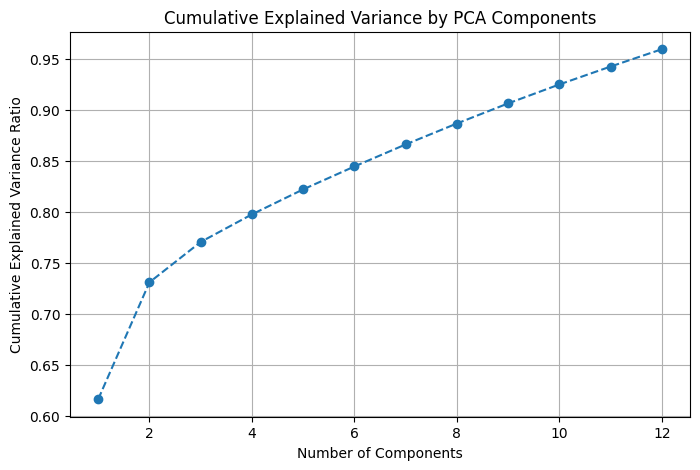


Shape of the original data (features only): (1100, 20)
Shape of the data after scaling (selected features): (1100, 15)
Shape of the PCA-transformed data: (1100, 13)


,0,1,2,3,4,5,6,7,8,9,10,11,stress_level
0,0.148856,-0.536854,-0.035662,-0.022654,0.005551,0.005156,0.140960,0.006384,0.045010,-0.090917,-0.093667,0.117152,1
1,-1.234252,0.050406,0.175986,-0.012119,-0.039023,0.066206,-0.289890,0.005005,-0.088539,0.162851,0.045393,-0.014175,2
2,0.182803,-0.539474,-0.195669,-0.062566,-0.001541,-0.122357,0.082489,0.164423,0.146593,-0.050205,-0.011979,0.062376,1
3,-1.011052,0.112635,0.104176,-0.017509,0.165083,-0.084268,-0.108312,-0.048129,-0.107739,0.063114,-0.012221,-0.013529,2
4,0.018227,0.495427,-0.023228,-0.468229,0.755811,-0.148659,-0.004214,-0.198861,-0.403085,-0.263779,0.310921,0.286686,1


<Figure size 640x480 with 0 Axes>

In [21]:
from sklearn.decomposition import PCA

# Dimensionality Reduction with PCA 95% on the scaled data using only the top 15 features
# Use the df_scaled dataframe and select the top 15 features
features_scaled_selected = df_scaled[top_15_features]

pca = PCA(n_components=0.95)
df_pca = pd.DataFrame(pca.fit_transform(features_scaled_selected))

# Display the explained variance ratio
print("Explained variance ratio by each component:")
print(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()
plt.savefig('cumulative_explained_variance.jpg') # Save the figure as a JPG file


# Add the target variable back to the PCA-transformed data from the original dataframe
df_pca['stress_level'] = df['stress_level'].values

print("\nShape of the original data (features only):", df.drop('stress_level', axis=1).shape) # Print original shape for comparison
print("Shape of the data after scaling (selected features):", features_scaled_selected.shape)
print("Shape of the PCA-transformed data:", df_pca.shape)

display(df_pca.head())

In [22]:
# Save the preprocessed dataframe to a CSV file
df_pca.to_csv('preprocessed_stress_level_dataset.csv', index=False)
print("Preprocessed dataset saved as 'preprocessed_stress_level_dataset.csv'")

Preprocessed dataset saved as 'preprocessed_stress_level_dataset.csv'
